# Alzheimers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    ReLU,
    Softmax,
)
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import image_dataset_from_directory, plot_model

In [2]:
class_names = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

In [3]:
train_ds = image_dataset_from_directory(
    directory="../alzheimers_dataset/train/",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="grayscale",
    batch_size=64,
    image_size=(200, 200),
    seed=42,
    validation_split=0.2,
    subset="training",
)

val_ds = image_dataset_from_directory(
    directory="../alzheimers_dataset/train/",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="grayscale",
    batch_size=64,
    image_size=(200, 200),
    seed=42,
    validation_split=0.2,
    subset="validation",
)

test_ds = image_dataset_from_directory(
    directory="../alzheimers_dataset/test/",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="grayscale",
    batch_size=64,
    image_size=(200, 200),
    seed=42,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


2024-03-28 00:04:39.395696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


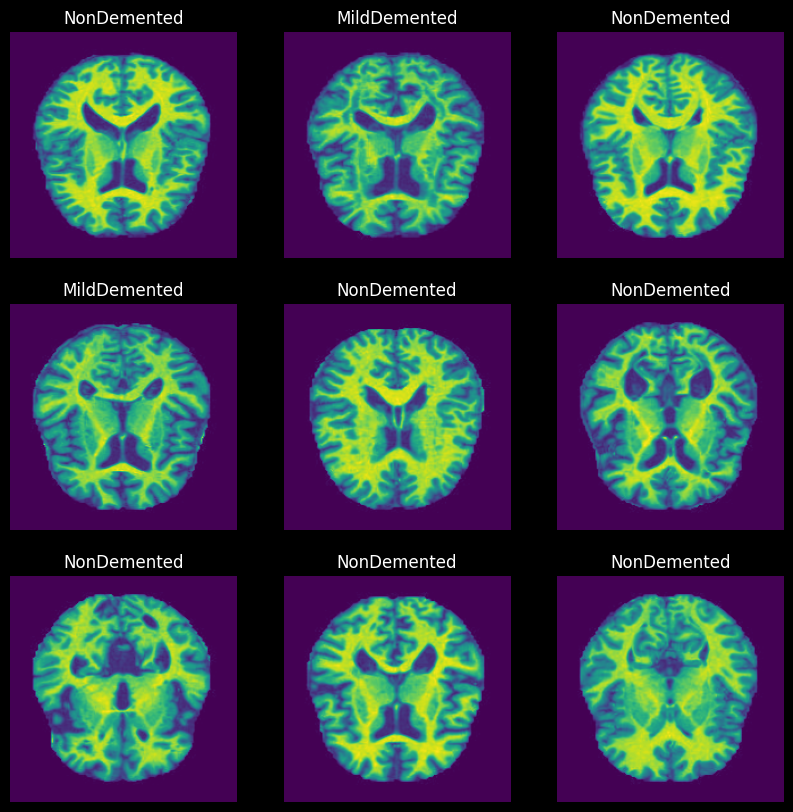

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # type: ignore
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [5]:
alzheimers = Sequential(
    layers=[
        Input(shape=(200, 200, 1)),
        Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
        ReLU(),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        Dense(32),
        ReLU(),
        Dense(4),
        Softmax(),
    ],
    name="alzheimers_cnn",
)

In [6]:
alzheimers.layers

[<Conv2D name=conv2d, built=True>,
 <ReLU name=re_lu, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <ReLU name=re_lu_1, built=True>,
 <Dense name=dense_1, built=True>,
 <Softmax name=softmax, built=True>]

In [7]:
alzheimers.summary()

Model: "alzheimers_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    10,240,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,240,484 (39.06 MB)

 Trainable params: 10,240,484 (39.06 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
alzheimers.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()],
)

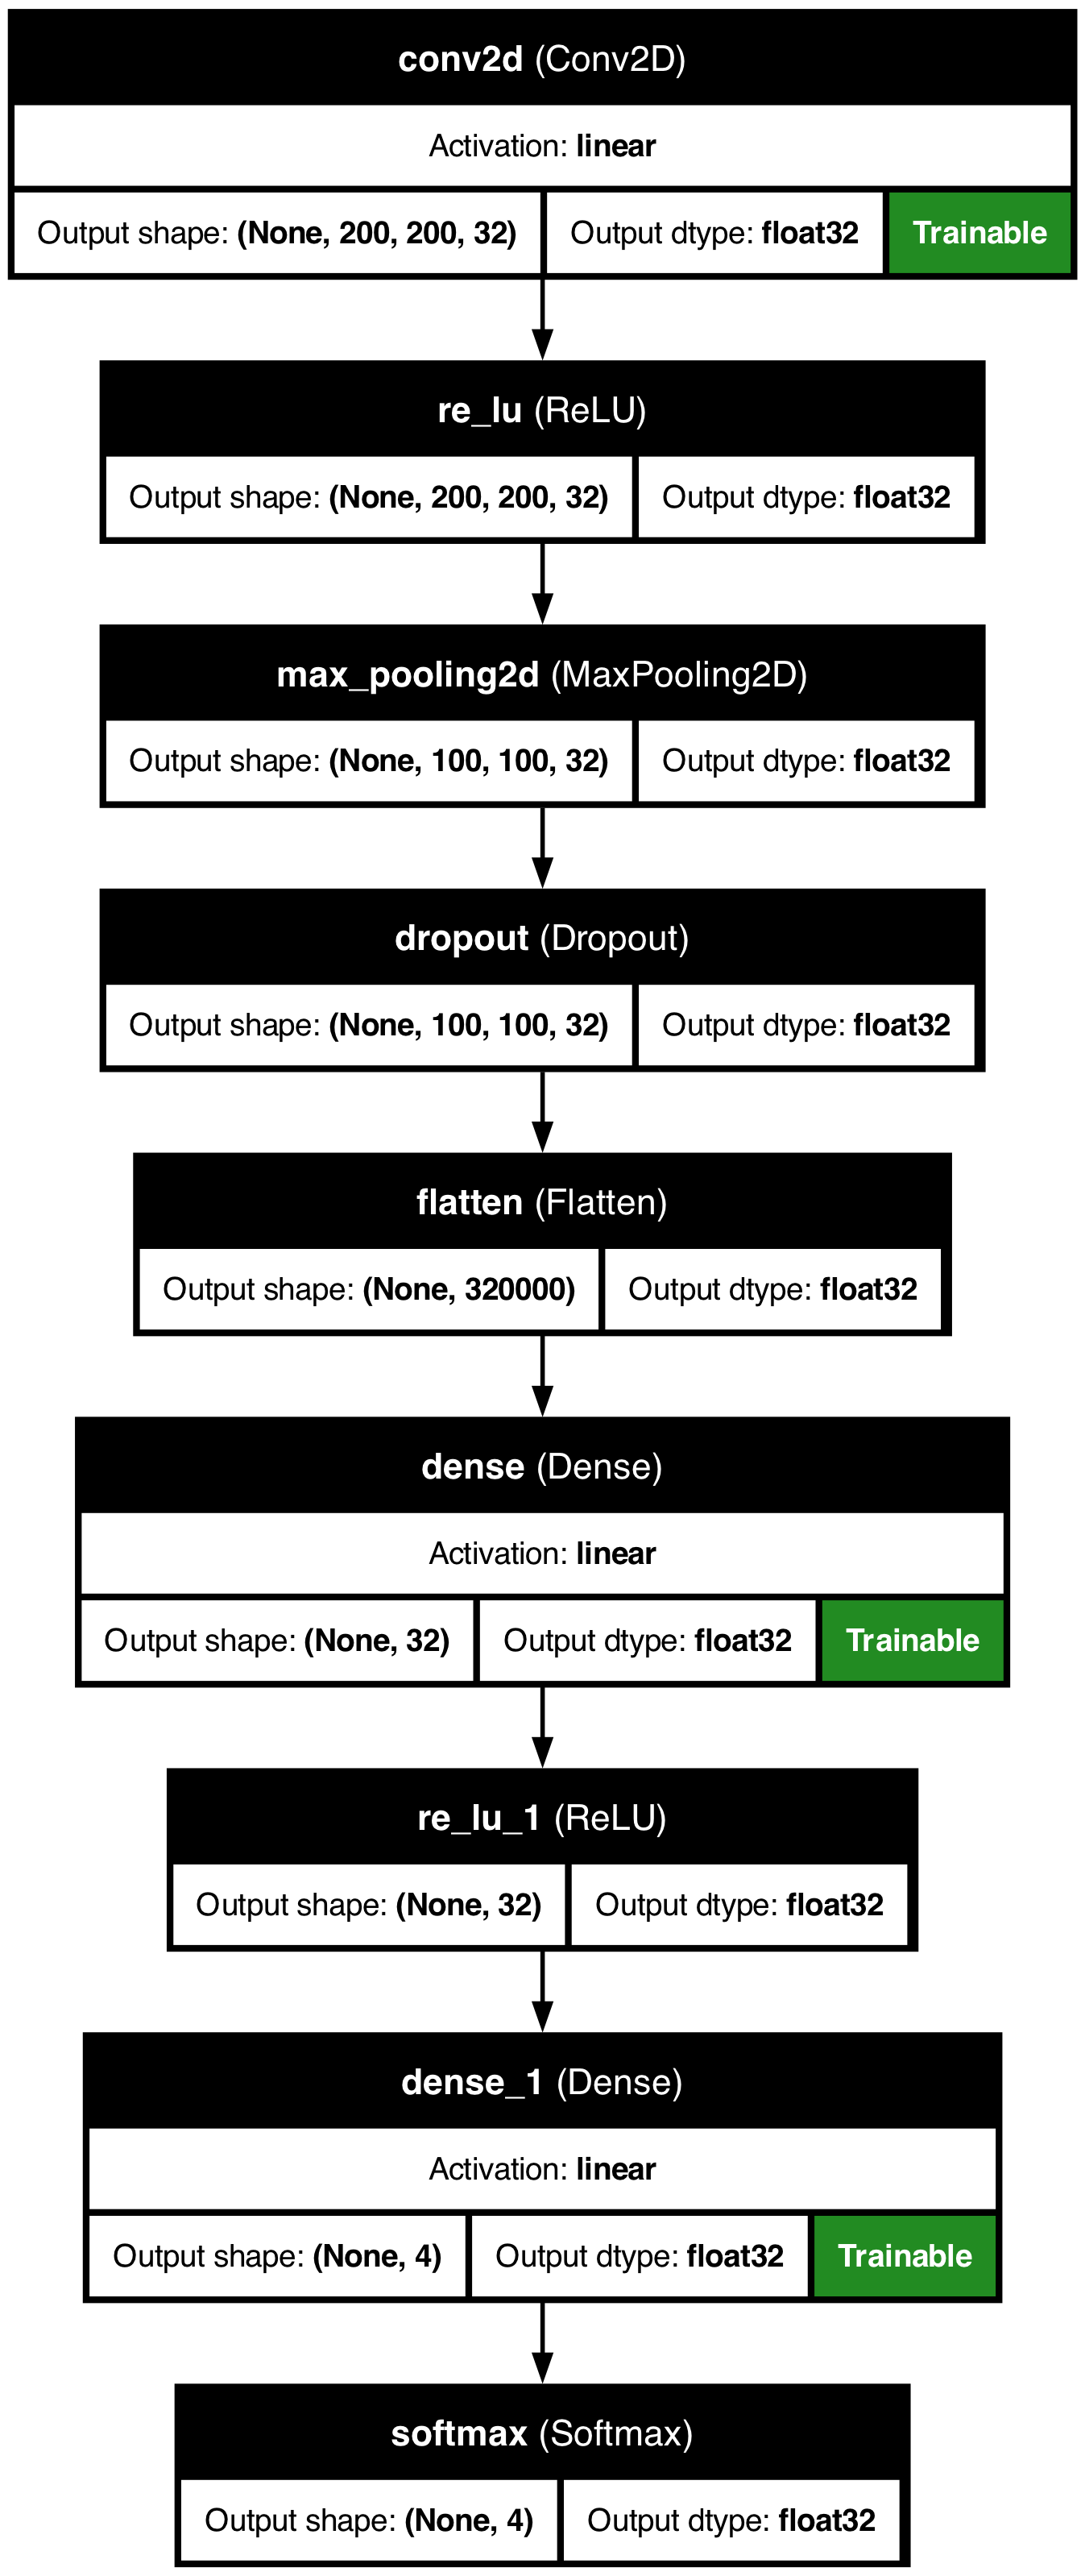

In [9]:
plot_model(
    alzheimers,
    to_file="Images/alzheimers_cnn.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [10]:
alzheimers_checkpoint_callback = ModelCheckpoint(
    filepath="../../../Models/alzheimers_cnn.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
)
alzheimers_tensorboard_callback = TensorBoard(
    log_dir="../../../Logs/alzheimers_cnn_logs",
    histogram_freq=1,
    write_images=True,
    write_steps_per_second=True,
)
# tensorboard --logdir="Logs/alzheimers_cnn_logs"

alzheimers_csvlogger_callback = CSVLogger("../../../Logs/alzheimers_cnn_logs.csv")

alzheimers_history = alzheimers.fit(
    train_ds,
    batch_size=64,
    epochs=10,
    validation_data=val_ds,
    callbacks=[
        alzheimers_checkpoint_callback,
        alzheimers_tensorboard_callback,
        alzheimers_csvlogger_callback,
    ],
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 48s 724ms/step - categorical_accuracy: 0.4055 - loss: 798.8151 - val_categorical_accuracy: 0.5195 - val_loss: 0.9885
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - categorical_accuracy: 0.5077 - loss: 1.0355 - val_categorical_accuracy: 0.5293 - val_loss: 0.9831
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - categorical_accuracy: 0.5225 - loss: 0.9949 - val_categorical_accuracy: 0.5430 - val_loss: 0.9514
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - categorical_accuracy: 0.5490 - loss: 0.9772 - val_categorical_accuracy: 0.5244 - val_loss: 1.0622
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - categorical_accuracy: 0.5172 - loss: 1.0430 - val_categorical_accuracy: 0.5703 - val_loss: 0.9324
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 414ms/step - categorical_accuracy: 0.5765 - loss: 0.9161 - val_categorical_accuracy: 0.5566 - val_loss: 0.9353
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 436ms/step - categorical_accuracy: 0.5

In [12]:
alzheimers_train_loss = alzheimers_history.history["loss"]
alzheimers_train_acc = alzheimers_history.history["categorical_accuracy"]
alzheimers_val_loss = alzheimers_history.history["val_loss"]
alzheimers_val_acc = alzheimers_history.history["val_categorical_accuracy"]


print("Training loss:", np.mean(alzheimers_train_loss))
print("Validation loss:", np.mean(alzheimers_val_loss))
print(
    "%f Training accuracy with a standard deviation of %f"
    % (np.mean(alzheimers_train_acc), np.std(alzheimers_train_acc))
)
print(
    "%f Validation accuracy with a standard deviation of %f"
    % (np.mean(alzheimers_val_acc), np.std(alzheimers_val_acc))
)

Training loss: 22.41322034597397
Validation loss: 0.9877720355987549
0.548182 Training accuracy with a standard deviation of 0.044510
0.532129 Validation accuracy with a standard deviation of 0.069040


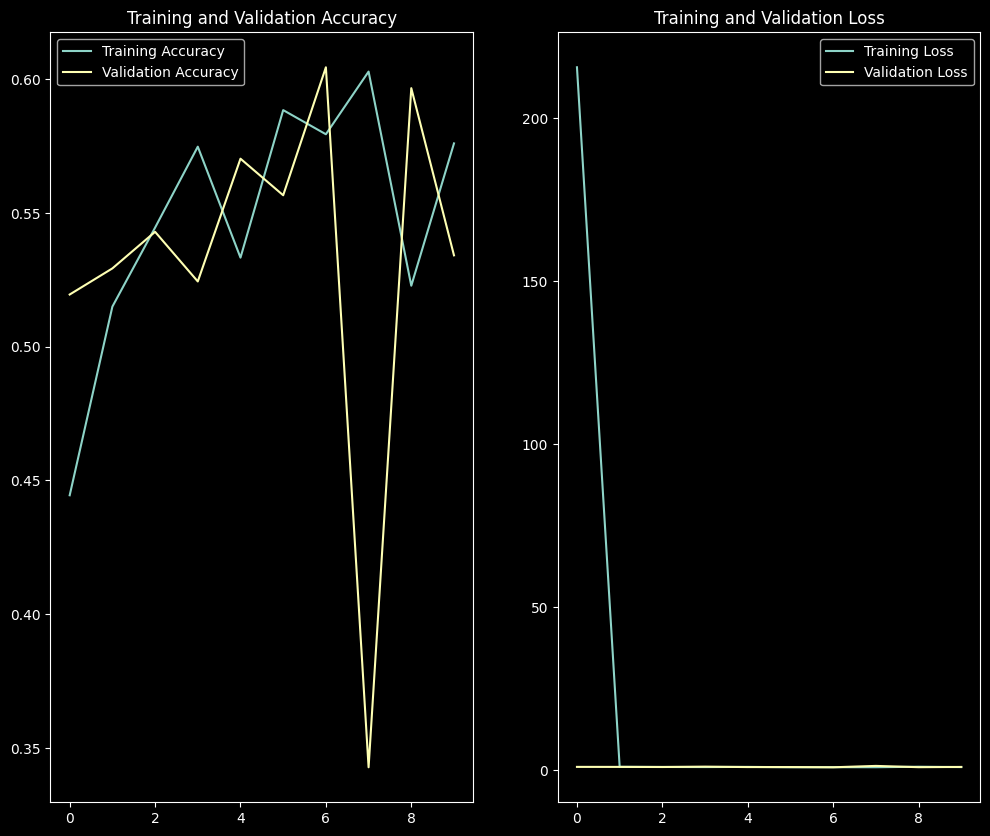

In [13]:
epochs_range = range(10)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, alzheimers_train_acc, label="Training Accuracy")
plt.plot(epochs_range, alzheimers_val_acc, label="Validation Accuracy")
plt.legend(loc="best")
plt.title("Training and Validation Accuracy")

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, alzheimers_train_loss, label="Training Loss")
plt.plot(epochs_range, alzheimers_val_loss, label="Validation Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss")

plt.savefig("Images/alzheimers_acc_loss.png", bbox_inches="tight")

In [14]:
alzheimers_test_loss, alzheimers_test_accuracy = alzheimers.evaluate(test_ds)
print("Test loss:", alzheimers_test_loss)
print("Test accuracy:", alzheimers_test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - categorical_accuracy: 0.5142 - loss: 1.0191
Test loss: 1.0272318124771118
Test accuracy: 0.5113369822502136


In [15]:
y_pred = alzheimers.predict(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
